# Readme
The purpose of this ipynb file is to prepare and fine tune the dataset before training and evaluating several continuous regression models.

In addition, SHAP analysis will be done for the best peforming model in order to analyse the model's feature importances. This is done for the project's Research Question 2.

- Input: csv file titled 'cleaned'
- Output: NIL 

---

# Content List

1. Importing
2. Read Dataset
3. Encoding
4. Model Training
5. Model Evaluation
6. SHAP Analysis

# 1. Importing

In [ ]:
# Mount google drive for google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Pip install SHAP library
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import relevant general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import io
import os
import os.path
import functools as ft

# Import relevant preprocessing libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from scipy import stats

# Import relevant modelling libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.stats import loguniform
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Import relevant model evaluation libraries
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import statsmodels.formula.api as smf

# Import SHAP library
import shap

# 2. Read Dataset

In [ ]:
# Check which out of 2 paths is working and set as 'path'
path = '/content/drive/My Drive/{}'
if not os.path.exists(path):
  path = '/content/drive/MyDrive/{}'

# Read in dataset from mounted Google Drive
df = pd.read_csv('{}cleaned.csv'.format(path), index_col=0)

# Read in 'nonull' dataset from mounted Google Drive
nonull = pd.read_csv('{}nonull.csv'.format(path), index_col=0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111846 entries, 431580018 to 119140025
Data columns (total 26 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   age                                                111846 non-null  int64  
 1   gender                                             111846 non-null  object 
 2   race                                               111846 non-null  object 
 3   marital                                            111846 non-null  object 
 4   education                                          111846 non-null  object 
 5   employment                                         111846 non-null  object 
 6   Academic                                           58621 non-null   float64
 7   Environment                                        58621 non-null   float64
 8   Family                                             58621 non-nu

# 3. Encoding

In [ ]:
# Make dataframe encoding with dummies
df_encoded = pd.get_dummies(
    df.drop(columns=['scoring']),
    drop_first=True)

In [ ]:
# Removing columns due to low significance level (>0.05)
df_encoded.drop(
    columns=[
        # Variables with high multi-colinearity
        # 'Academic',
        # 'Environment',
        # 'Family',
        # 'Financial',
        # 'Housing',
        # 'Legal',
        # 'Social',

        # Below here cause of low significance P value
        'Occupational',
        'fh_Bipolar disorder',
        'fh_Others',
        'fh_Pervasive and specific developmental disorders',
        'fh_Substance-related disorders',
        'race_Others',
        'race_White',
        'marital_Separated',
        'marital_Single',
        'education_No formal education',
        'education_Received higher education',
        'employment_Unemployed',
    ],
    inplace=True
)

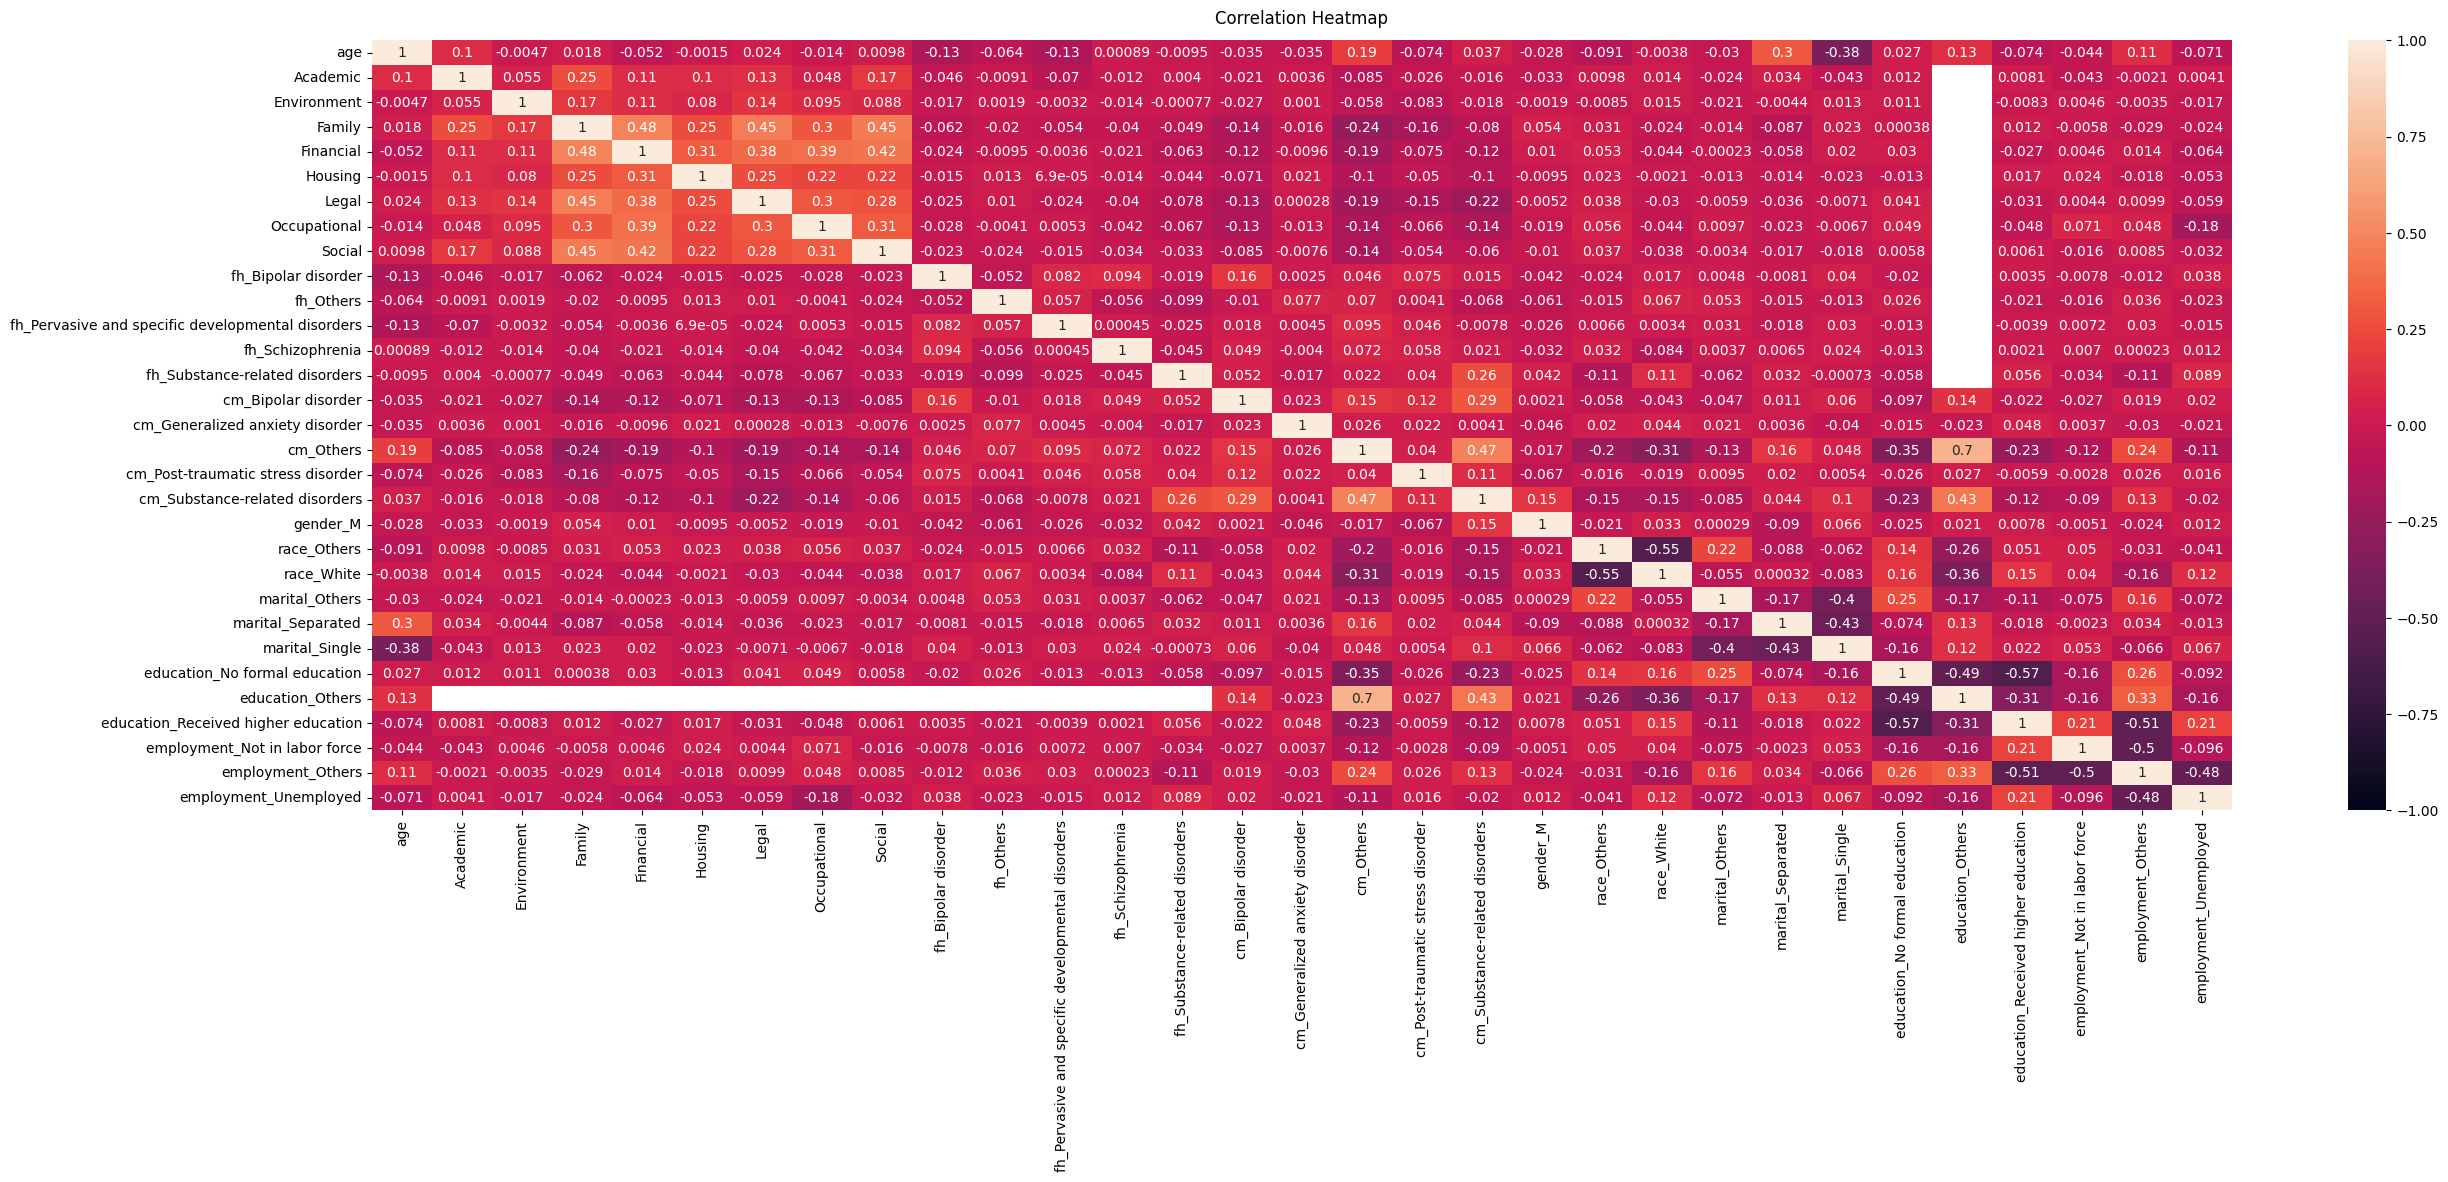

In [ ]:
# Correlation Heatmap of encoded independant variables
plt.figure(figsize=(30, 10))
heatmap = sns.heatmap(df_encoded.drop(columns=['z_score']).corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
# Fill all NaN values with 0
df_encoded.fillna(0,inplace=True)

# 4. Model Training

In [ ]:
# Split df_encoded into dfs with independent and dependent variables
df_y = df_encoded['z_score']
df_x = df_encoded.drop(columns = ['z_score'])

In [ ]:
# Train-test split for independant and dependant variables
X_train, X_test, y_train, y_test = train_test_split(df_x,df_y, test_size=0.30)

In [ ]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [ ]:
calc_vif(df_x)

,variables,VIF
0,age,7.242058
1,Academic,3924.563761
2,Environment,3426.259570
3,Family,3023.095469
4,Financial,2369.297578
5,Housing,4330.429526
6,Legal,6472.955314
7,Occupational,3394.025109
8,Social,3125.627098
9,fh_Bipolar disorder,1.164597


In [ ]:
# Preliminary model analysis to check for P value
# - works only dataframes with no nulls
X2 = sm.add_constant(df_x)
est = sm.OLS(df_y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                z_score   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     7130.
Date:                Fri, 07 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:53:15   Log-Likelihood:                -82271.
No. Observations:              111846   AIC:                         1.646e+05
Df Residuals:                  111814   BIC:                         1.649e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [ ]:
# # Randomized Search for Gradient Boosting Regression model

# model = Ridge()
# # define evaluation
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define search space
# space = dict()
# space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
# space['alpha'] = loguniform(1e-5, 100)
# space['fit_intercept'] = [True, False]
# # space['normalize'] = [True, False]
# # define search
# search = RandomizedSearchCV(model, space, n_iter=12, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)
# # execute search
# result = search.fit(X_train, y_train)
# # summarize result
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)

In [ ]:
# Results for n_iter = 10 (25s)
# Best Score: -0.3396725499558038
# Best Hyperparameters: {'alpha': 0.008597290483171274, 'fit_intercept': True, 'solver': 'svd'}

In [ ]:
# GridSearch for Gradient Boosting Regression model
# grid_GBR = GridSearchCV(estimator=model_4, param_grid = parameters, cv = 2, n_jobs=-1,verbose=10)
# grid_GBR.fit(X_train, y_train)  

In [ ]:
# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
# print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
# print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

In [ ]:
# Call and fit models on train df sets

# Model & label 1 for Linear Regression
model_1 = LinearRegression(fit_intercept=False)
model_1.fit(X_train, y_train)
pred_1 = model_1.predict(X_test)

# Model & label 2 for XGB Regressor
model_2 = xgb.XGBRegressor()
model_2.fit(X_train, y_train)
pred_2 = model_2.predict(X_test)

# Model & label 3 for Random Forest Regressor
model_3 = RandomForestRegressor()
model_3.fit(X_train, y_train)
pred_3 = model_3.predict(X_test)

# Model & label 4 for Gradient Boosting Regressor
model_4 = GradientBoostingRegressor()
model_4.fit(X_train, y_train)
pred_4 = model_4.predict(X_test)

# Model & label 5 for Gradient Boosting Regressor with optimum hyperparameters
model_5 = GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=500, subsample=0.5)
model_5.fit(X_train, y_train)
pred_5 = model_5.predict(X_test)

# Model & label 6 for Ridge Regressor with optimum hyperparameters
model_6 = Ridge(alpha=0.008597290483171274, fit_intercept=True, solver='svd')
model_6.fit(X_train, y_train)
pred_6 = model_6.predict(X_test)

# Model & label 7 for Lasso Regressor with optimum hyperparameters
model_7 = Lasso(alpha=0.01)
model_7.fit(X_train, y_train)
pred_7 = model_7.predict(X_test)

# Model & label 8 for ElasticNet Regressor with optimum hyperparameters
model_8 = ElasticNet(alpha=0.01)
model_8.fit(X_train, y_train)
pred_8 = model_8.predict(X_test)

# Model & label 9 for Polynomial Regression with optimum hyperparameters
model_9 = PolynomialFeatures(degree=2, include_bias=False)
poly_X_train = model_9.fit_transform(X_train)
poly_X_test = model_9.fit_transform(X_test)
regression_model = LinearRegression()
regression_model.fit(poly_X_train, y_train)
pred_9 = regression_model.predict(poly_X_test)

# 5. Model Evaluation

In [ ]:
# R2 Score
score=r2_score(y_test,pred_1)
print('Linear Regression r2 score: ',score)
score=r2_score(y_test,pred_2)
print('XGB r2 score: ',score)
score=r2_score(y_test,pred_3)
print('Random Forest r2 score: ',score)
score=r2_score(y_test,pred_4)
print('Gradient Boosting r2 score: ',score)
score=r2_score(y_test,pred_5)
print('Gradient Boosting Tuned r2 score: ',score)
score=r2_score(y_test,pred_6)
print('Ridge Tuned r2 score: ',score)
score=r2_score(y_test,pred_7)
print('Lasso Tuned r2 score: ',score)
score=r2_score(y_test,pred_8)
print('ElasticNet Tuned r2 score: ',score)
score=r2_score(y_test,pred_9)
print('Polynomial Regression r2 score: ',score)

Linear Regression r2 score:  0.6616462769717582
XGB r2 score:  0.6799117692587515
Random Forest r2 score:  0.6639847318670731
Gradient Boosting r2 score:  0.6862044883647807
Gradient Boosting Tuned r2 score:  0.684348087047739
Ridge Tuned r2 score:  0.6642822775164836
Lasso Tuned r2 score:  0.5930820563121083
ElasticNet Tuned r2 score:  0.43981595392014994
Polynomial Regression r2 score:  0.6699485008656924


In [ ]:
# Mean Squared Error
print('Linear Regression MSE: ',mean_squared_error(y_test,pred_1))
print('XGB MSE: ',mean_squared_error(y_test,pred_2))
print('Random Forest MSE: ',mean_squared_error(y_test,pred_3))
print('Gradient Boosting MSE: ',mean_squared_error(y_test,pred_4))
print('Gradient Boosting Tuned MSE: ',mean_squared_error(y_test,pred_5))
print('Ridge Tuned MSE: ',mean_squared_error(y_test,pred_6))
print('Lasso Tuned MSE: ',mean_squared_error(y_test,pred_7))
print('ElasticNet Tuned MSE: ',mean_squared_error(y_test,pred_8))
print('Polynomial Regression MSE: ',mean_squared_error(y_test,pred_9))

Linear Regression MSE:  0.2556717095749058
XGB MSE:  0.24186967542718915
Random Forest MSE:  0.2539046926332921
Gradient Boosting MSE:  0.23711468045531817
Gradient Boosting Tuned MSE:  0.23851744113469606
Ridge Tuned MSE:  0.25367985690758915
Lasso Tuned MSE:  0.30748119272417374
ElasticNet Tuned MSE:  0.42329433072580225
Polynomial Regression MSE:  0.24939826367563134


In [ ]:
# Root Mean Squared Error
print('Linear Regression RMSE: ',np.sqrt(mean_squared_error(y_test,pred_1)))
print('XGB RMSE: ',np.sqrt(mean_squared_error(y_test,pred_2)))
print('Random Forest RMSE: ',np.sqrt(mean_squared_error(y_test,pred_3)))
print('Gradient Boosting RMSE: ',np.sqrt(mean_squared_error(y_test,pred_4)))
print('Gradient Boosting Tuned RMSE: ',np.sqrt(mean_squared_error(y_test,pred_5)))
print('Ridge Tuned RMSE: ',np.sqrt(mean_squared_error(y_test,pred_6)))
print('Lasso Tuned RMSE: ',np.sqrt(mean_squared_error(y_test,pred_7)))
print('ElasticNet Tuned RMSE: ',np.sqrt(mean_squared_error(y_test,pred_8)))
print('Polynomial Regression RMSE: ',np.sqrt(mean_squared_error(y_test,pred_9)))

Linear Regression RMSE:  0.5268520400386455
XGB RMSE:  0.506287962153495
Random Forest RMSE:  0.5255407596955656
Gradient Boosting RMSE:  0.5040576142272668
Gradient Boosting Tuned RMSE:  0.5039943430475562
Ridge Tuned RMSE:  0.5196713735492077
Lasso Tuned RMSE:  0.5710489345785784
ElasticNet Tuned RMSE:  0.6692425963434715
Polynomial Regression RMSE:  0.5159563399719688


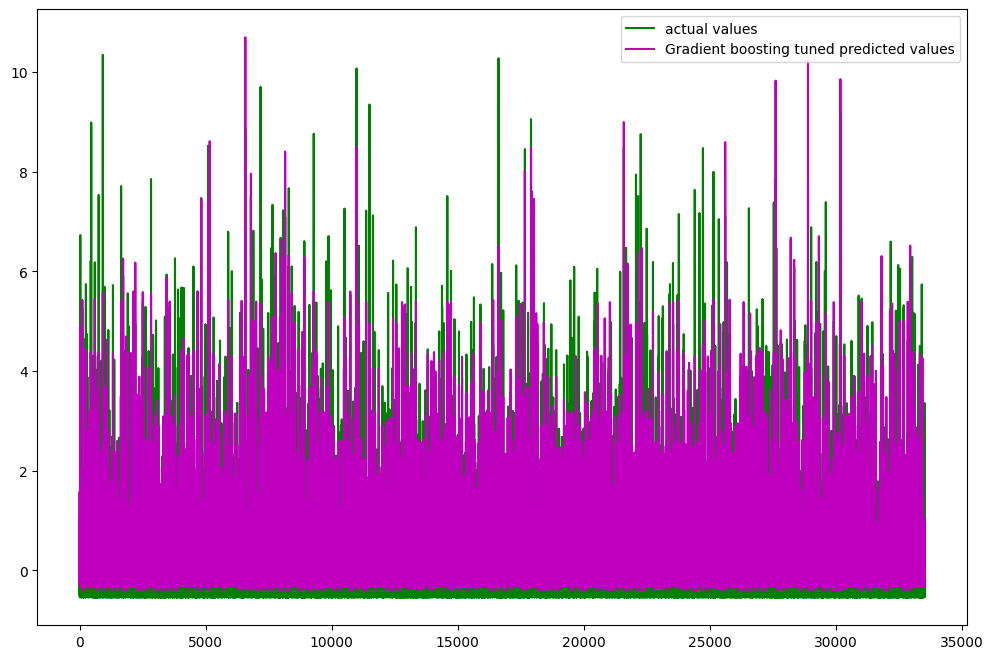

In [ ]:
# Plot for Gradient Boosting Regressor Tuned

# figure size
plt.figure(figsize=(12, 8))

# acutal values
plt.plot([i for i in range(len(y_test))],np.array(y_test), c='g', label="actual values")

# predicted values
plt.plot([i for i in range(len(y_test))],pred_4, c='m',label="Gradient boosting tuned predicted values")
plt.legend()
plt.show()

# 6. SHAP Analysis

In [ ]:
# SHAP analysis for Gradient Boosting Regressor
explainer_4 = shap.Explainer(model_4.predict, X_train)
shap_values_4 = explainer_4(X_test)

Permutation explainer: 33555it [30:21, 18.35it/s]                           


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


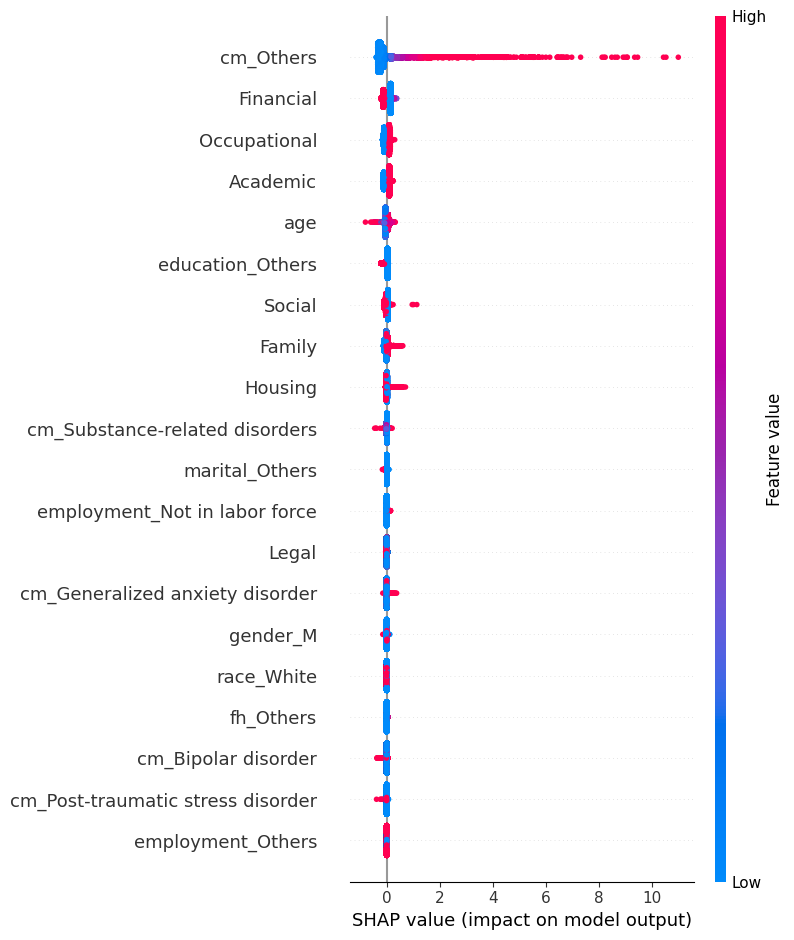

In [ ]:
shap.summary_plot(shap_values_4)